<h1><center>Sepsis Prediction</h1>
<h4>TCSS 555<br>
Spring 2018<br>
Thuan Lam, Tood Robbins, Inno Irving Estrera</h4></center>


<h2>Libraries</h2>

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from dateutil.parser import parse
from datetime import datetime

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

## Data

In [2]:
import os 
cwd = os.getcwd()
print('Current folder is {}'.format(cwd))

if os.name == "posix":
    unreadable = set([       
        "NEW_CHARTEVENTS.csv",
        "ADMISSIONS.csv",
        "NEW_ICUSTAYS.csv",
        "DRGCODES.csv"
    ])
    USER_DIR = '/Users/innoestrera/Desktop/mimic3/';
else:
    USER_DIR = 'C:\mimic3\\';
print(USER_DIR)

Current folder is C:\Users\toddr\Project-3-Sepsis
C:\mimic3\


In [3]:
# Load datasets
admissions = pd.read_csv("{}ADMISSIONS.csv".format(USER_DIR))[['HADM_ID','SUBJECT_ID','DIAGNOSIS']]
# convert Diagnosis to binary: 1 means sepsis
admissions['DIAGNOSIS'] = admissions['DIAGNOSIS'].apply(lambda x : 0 if str(x).find('SEPSIS') == -1 else 1)
# print(admissions.head(2))
# adminssions = shuffle(stays)

drugs = pd.read_csv("{}DRGCODES.csv".format(USER_DIR))[['HADM_ID','SUBJECT_ID','DRG_CODE','DESCRIPTION']]

stays = pd.read_csv("{}NEW_ICUSTAYS.csv".format(USER_DIR))[['HADM_ID','ICUSTAY_ID','LOS']]
# print(stays.head(1))

chart = pd.read_csv("{}NEW_CHARTEVENTS.csv".format(USER_DIR))
# print(chart.head(2))

## Create the Y Set

In [4]:
#get a copy with 2 columns only
find_sepsis = drugs[['HADM_ID', 'DRG_CODE']].copy()

#change drug code 870, 871, 872 to 1; Otherwise, 0
#https://www.icd10monitor.com/understanding-sepsis-an-example-of-the-convergence-of-clinical-quality-coding-reimbursement-and-audit
find_sepsis['DRG_CODE'] = find_sepsis['DRG_CODE'].apply(lambda x: 1 if (x >= 870 and x <= 872) or (x >= 867 and x <= 869) or x == 776 or (x >= 974 and x <= 976) else 0)

#sum all drugcodes grouup by HADM_ID. If the sum > 0 means HADM_ID has/had sepsis
find_sepsis = find_sepsis.groupby(['HADM_ID']).sum().reset_index() # .sort_values(by=['DRG_CODE'], ascending=False)

#convert DRG_CODE to binary: 1 means sepsis, 0 means NO
find_sepsis['DRG_CODE'] = find_sepsis['DRG_CODE'].apply(lambda x: 1 if x > 0 else 0)

#change DRG_CODR to SEPSIS, it would be easier 
find_sepsis.rename(columns={'DRG_CODE': 'SEPSIS'}, inplace=True)

# print('find_sepsis: ')
# print(find_sepsis.head(2))
# print('admission1: ')
# print(admissions.head(2))

#merge tables to create the Y set
admissions = pd.merge(admissions, find_sepsis, on='HADM_ID', how='left') #.drop(['SUBJECT_ID'], axis=1)
admissions = admissions.fillna(0)
# print('admission2: ')
# print(admissions.head(2))

# admissions.loc[admissions['SEPSIS'] > 0]

## Create the X Set

* <h3>Master

In [5]:
master = pd.merge(admissions, stays, on='HADM_ID', how='inner') #.drop(['SUBJECT_ID'], axis=1)
# print(master.head(3))

* <h3>Get ItemIDs from ChartEvents then Add into Master

In [6]:
# get itemsIds from ChartEvent
for x in chart.ITEMID.unique():
    master[x] = 0

# set index
master = master.set_index('ICUSTAY_ID')
# print(master.head(2))

* <h3>Put Item's Values into Master

In [7]:
for index, row in chart.iterrows():    
    master.loc[row['ICUSTAY_ID'], row['ITEMID']] = row['VALUE']
# print(master.head(2))

* <h3>Add DrugCodes into Master

In [8]:
master = master.reset_index()
drugs = drugs.loc[drugs['DRG_CODE'].isin(['870','871','872'])]
drugColumns = pd.merge(drugs, stays, on='HADM_ID', how='inner').drop(['HADM_ID', 'SUBJECT_ID', 'DESCRIPTION', 'LOS'], axis=1)
print('Number of Items/Columns need to be added: ', drugColumns.DRG_CODE.unique().size)
for x in drugColumns.DRG_CODE.unique():
    drugColumns[x]=(drugColumns.DRG_CODE==x).astype(int)
    
drugColumns = drugColumns.groupby(['ICUSTAY_ID']).sum().reset_index()
drugColumns = drugColumns.drop(['DRG_CODE'], axis=1)
master = pd.merge(master, drugColumns, on='ICUSTAY_ID', how='left')
master.fillna(0)
print('Master built. Shape: {}'.format(master.shape))


Number of Items/Columns need to be added:  3
Master built. Shape: (51696, 20)


* <h3>Finalize the Master

In [9]:
# move the SEPSIS column to the last 
cols = master.columns.tolist()
cols.insert(len(master.columns) - 1, cols.pop(cols.index('SEPSIS')))
master = master.reindex(columns= cols).reset_index()

# remove unnecessary columns
master.drop(['ICUSTAY_ID','HADM_ID','SUBJECT_ID'], axis=1, inplace=True)
# print(master.head(2))
print('Master built. Shape: {}'.format(master.shape))
print(master.columns.values)

master.fillna(0, inplace=True)
master = shuffle(master)
# master = master[:30000]

# checking null
ol_mask=master.isnull().any(axis=0) 
ol_mask

Master built. Shape: (51696, 18)
['index' 'DIAGNOSIS' 'LOS' 220615 225690 198 828 1525 490 226755 438 2981
 227010 227023 870 871 872 'SEPSIS']


index        False
DIAGNOSIS    False
LOS          False
220615       False
225690       False
198          False
828          False
1525         False
490          False
226755       False
438          False
2981         False
227010       False
227023       False
870          False
871          False
872          False
SEPSIS       False
dtype: bool

## Analyze

,SEPSIS,sepsis_counts,total_stays,sepsis_percent
0,1.0,1815,49881,3.63866


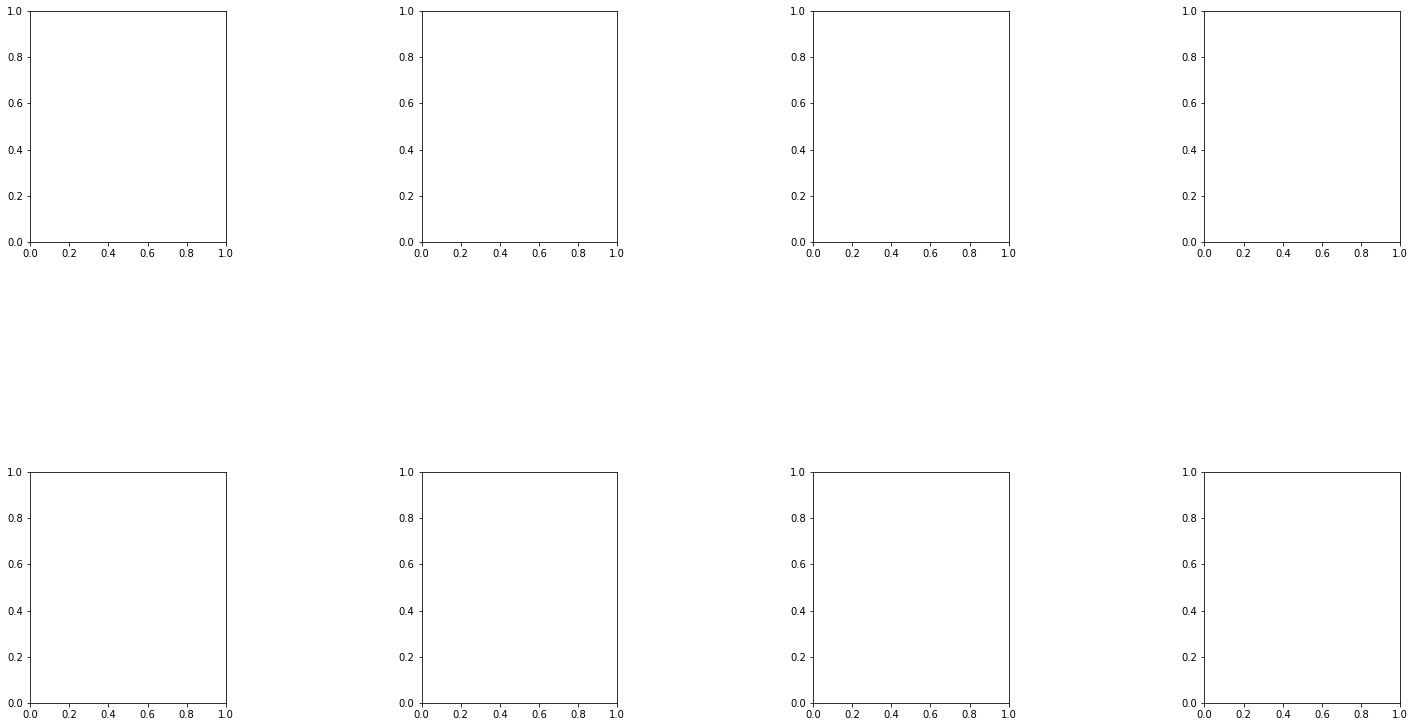

In [10]:
sepsis_only = master[master['SEPSIS']==1]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,15))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
fig.set_size_inches(20, 10)
plt.subplots_adjust(wspace=1, hspace=1)

# Gender
g = sepsis_only.groupby(['SEPSIS']).size().reset_index(name='sepsis_counts')
g['total_stays'] = master.groupby(['SEPSIS']).size().reset_index(name='total_stays')['total_stays']
g['sepsis_percent'] = g.apply(lambda row: row.sepsis_counts / row.total_stays * 100, axis=1)
g
# g = g.drop(columns=['sepsis_counts','total_stays'])
# g.iloc[0, g.columns.get_loc('SEPSIS')] = 'No Sepsis'
# g.iloc[1, g.columns.get_loc('SEPSIS')] = 'Sepsis'
# g = g.set_index('gender')
# g.plot.bar(subplots=True, legend=None, ax=axes[0,0], rot=0, fontsize=12)

In [11]:
master

,index,DIAGNOSIS,LOS,220615,225690,198,828,1525,490,226755,438,2981,227010,227023,870,871,872,SEPSIS
38288,38288,0,3.0458,0.850000,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23310,23310,0,0.8343,0.000000,0.00,10.666667,126.000000,0.900000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27881,27881,0,2.7082,1.400000,0.00,15.000000,454.000000,1.400000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5672,5672,0,1.4911,0.000000,0.00,15.000000,148.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49951,49951,0,0.8034,0.700000,0.50,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19785,19785,0,6.4314,0.000000,0.00,6.928571,110.000000,2.400000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6213,6213,0,1.0893,0.000000,0.00,15.000000,242.000000,1.500000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12193,12193,0,8.8596,0.000000,0.00,15.000000,415.000000,3.766667,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41450,41450,0,1.0249,1.050000,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41855,41855,0,3.5842,0.900000,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model

In [12]:
# Split-out validation dataset
col = len(master.columns) - 1
array = master.values   #numpy array
X = array[:,0:col]# first N columns
Y = array[:,col]  # SEPSIS column

In [13]:
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)
# print('{}'.format(X_train, Y_train))

In [14]:
# Test options and evaluation metric
seed = 7
scoring = 'accuracy'

# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.974103 (0.012627)
KNN: 0.963077 (0.003119)
CART: 0.994463 (0.001300)
NB: 0.946272 (0.006218)
RF: 0.997195 (0.000668)


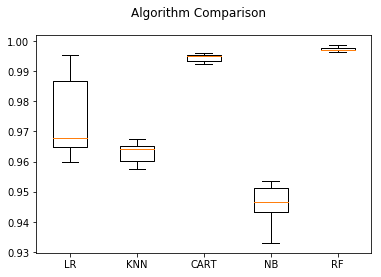

In [15]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

accuracy 0.9870406189555125
confusion Matrix [[9973    3]
 [ 131  233]]
             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99      9976
        1.0       0.99      0.64      0.78       364

avg / total       0.99      0.99      0.99     10340

precision [0.03520309 0.98728814 1.        ]
recall [1.         0.64010989 0.        ]
sensitivity 0.9996992782678428
specificity 0.6401098901098901
stuff (array([0.00000000e+00, 3.00721732e-04, 1.00000000e+00]), array([0.        , 0.64010989, 1.        ]), array([2., 1., 0.]))


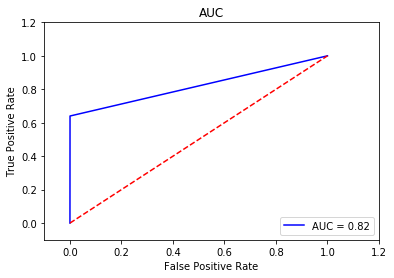

accuracy 0.9636363636363636
confusion Matrix [[9961   15]
 [ 361    3]]
             precision    recall  f1-score   support

        0.0       0.97      1.00      0.98      9976
        1.0       0.17      0.01      0.02       364

avg / total       0.94      0.96      0.95     10340

precision [0.03520309 0.16666667 1.        ]
recall [1.         0.00824176 0.        ]
sensitivity 0.9984963913392141
specificity 0.008241758241758242
stuff (array([0.        , 0.00150361, 1.        ]), array([0.        , 0.00824176, 1.        ]), array([2., 1., 0.]))


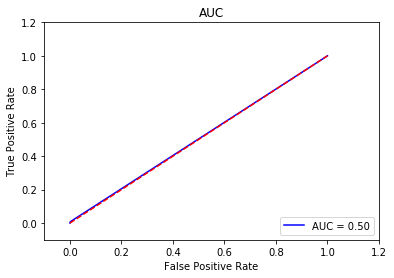

accuracy 0.9923597678916828
confusion Matrix [[9938   38]
 [  41  323]]
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      9976
        1.0       0.89      0.89      0.89       364

avg / total       0.99      0.99      0.99     10340

precision [0.03520309 0.89473684 1.        ]
recall [1.         0.88736264 0.        ]
sensitivity 0.9961908580593424
specificity 0.8873626373626373
stuff (array([0.        , 0.00380914, 1.        ]), array([0.        , 0.88736264, 1.        ]), array([2., 1., 0.]))


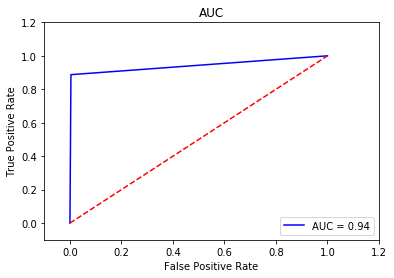

accuracy 0.9462282398452612
confusion Matrix [[9544  432]
 [ 124  240]]
             precision    recall  f1-score   support

        0.0       0.99      0.96      0.97      9976
        1.0       0.36      0.66      0.46       364

avg / total       0.96      0.95      0.95     10340

precision [0.03520309 0.35714286 1.        ]
recall [1.         0.65934066 0.        ]
sensitivity 0.9566960705693665
specificity 0.6593406593406593
stuff (array([0.        , 0.04330393, 1.        ]), array([0.        , 0.65934066, 1.        ]), array([2., 1., 0.]))


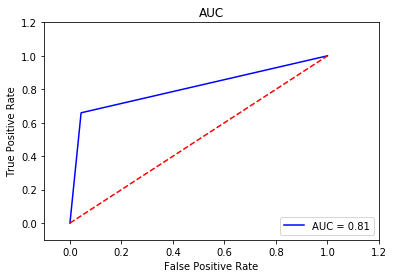

accuracy 0.9960348162475822
confusion Matrix [[9976    0]
 [  41  323]]
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      9976
        1.0       1.00      0.89      0.94       364

avg / total       1.00      1.00      1.00     10340

precision [0.03520309 1.         1.        ]
recall [1.         0.88736264 0.        ]
sensitivity 1.0
specificity 0.8873626373626373
stuff (array([0., 1.]), array([0.88736264, 1.        ]), array([1., 0.]))


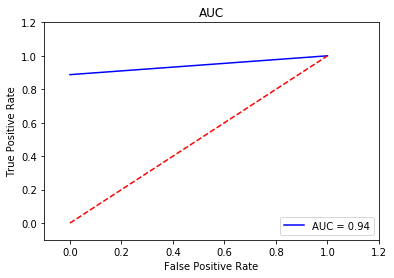

In [20]:
# Make predictions on validation dataset

messages = []
matrices = []
for name, model in models:
    model.fit(X_train, Y_train)
    prediction = model.predict(X_validation)
    
    accuracyScore = accuracy_score(Y_validation, prediction)
    confusionMatrix = confusion_matrix(Y_validation, prediction)
    classificationReport = classification_report(Y_validation, prediction)
    precision, recall, thresholds = precision_recall_curve(Y_validation, prediction)
    sensitivity = confusionMatrix[0, 0]/(confusionMatrix[0, 0]+confusionMatrix[0, 1])
    specificity = confusionMatrix[1, 1]/(confusionMatrix[1, 0]+confusionMatrix[1, 1])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_validation, prediction)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    #metrics.roc_curve(Y_validation, prediction)
    #auc = metrics.auc(confusionMatrix[0, 0], confusionMatrix[1, 1])
    
    print("accuracy", accuracyScore)
    print("confusion Matrix", confusionMatrix)
    print(classificationReport)
    print("precision", precision)
    print("recall", recall)
    print("sensitivity", sensitivity)
    print("specificity", specificity)
    print("stuff", roc_curve(Y_validation, prediction))
    plt.title('AUC')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    #matrices.append(confusionMatrix)
    
#print(confusionMatrix)
#print(messages)

## Conclusion

<h4> bla bla bla. <h4>